In [1]:
import numpy as np
import pywt
import subprocess
from sklearn.model_selection import KFold
import scipy.sparse as sp
from scipy.stats import siegelslopes
import matplotlib.pyplot as plt
wvt = 'db12'

In [2]:
%run -i "Snippets/common_functions_and_variables.py"

In [3]:
das_data = np.load("Data/filtdas.npy")
no_nodes_selector = np.load("tmp/no_nodes_selector.npy")

In [4]:
nodal_data = np.load("Data/nodal_rotated_data.npy")
nodal_data_x = nodal_data[0]
nodal_data_y = nodal_data[1]

In [5]:
best_offset = 17 # determined by fitting DAS reconstruction using all nodes to the DAS data

In [6]:
das_data = das_data[:, (150-best_offset) : (550-best_offset)]
nodal_data_x = nodal_data_x[:, 150:550]
nodal_data_y = nodal_data_y[:, 150:550]

In [7]:
das_stds = np.std(das_data, axis=1)
nodal_x_stds = np.std(nodal_data_x, axis=1)
nodal_y_stds = np.std(nodal_data_y, axis=1)

In [8]:
#normalize each channel
das_data = das_data / das_stds[:, np.newaxis]
nodal_data_x = nodal_data_x / nodal_x_stds[:, np.newaxis]
nodal_data_y = nodal_data_y / nodal_y_stds[:, np.newaxis]

In [9]:
das_wvt_data = np.array([np.hstack(pywt.wavedec(d, wvt)) for d in das_data])
nodal_wvt_data_x = np.array([np.hstack(pywt.wavedec(d, wvt)) for d in nodal_data_x])
nodal_wvt_data_y = np.array([np.hstack(pywt.wavedec(d, wvt)) for d in nodal_data_y])

In [10]:
wvt_tmp = pywt.wavedec(das_data[0], wvt)
wvt_lens = [len(wc) for wc in wvt_tmp]

In [11]:
Gn_das = 5.487292209780819e-06
Gn_nodes = 0.0003260777891832482

In [12]:
#Normalize the G matrix
G_das = np.load("Data/G.npy")*Gn_das
G_nodes = np.load("Data/nodal_G.npy")*Gn_nodes

In [13]:
nodal_wvt_data_train_full = np.vstack([nodal_wvt_data_x,
                             nodal_wvt_data_y])
G_nodes_train_full = np.vstack([np.hstack([G_nodes/nodal_x_stds[:, np.newaxis], np.zeros(G_nodes.shape)]),
                          np.hstack([np.zeros(G_nodes.shape), G_nodes/nodal_y_stds[:, np.newaxis]])])

Gn_nodes_full = np.std(G_nodes_train_full)
G_nodes_train_full = G_nodes_train_full / Gn_nodes_full 

np.save("tmp/data.npy", nodal_wvt_data_train_full)
np.save("tmp/G.npy",  G_nodes_train_full)
subprocess.run(f"/Applications/Julia-1.5.app/Contents/Resources/julia/bin/julia combinedinversion.jl all_nodes", shell=True, env={"JULIA_NUM_THREADS" : "12"})
res = sp.load_npz(f"Combined_Results/combined_results_all_nodes.npz")

In [14]:
G_das_predict = G_das/das_stds[:, np.newaxis]/Gn_das
das_wvt_data_predict = G_das_predict @ res

In [15]:
das_wvt_data_predict.shape

(7646, 490)

0.04513247743577464 -0.0005946214099193321


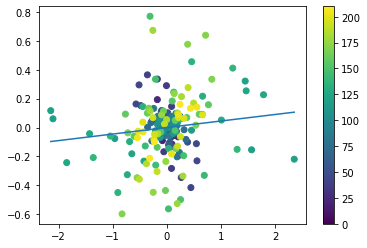

In [16]:
i = 15
j = 4
jj1 = 0 if j == 0 else np.cumsum(wvt_lens)[j-1]
jj2 = np.cumsum(wvt_lens)[j]
plt.scatter(das_wvt_data[i,jj1:jj2], das_wvt_data_predict[i,jj1:jj2], c=range(wvt_lens[j]))
slope, intercept = siegelslopes(das_wvt_data_predict[i,jj1:jj2], das_wvt_data[i,jj1:jj2])
x = np.linspace(np.min(das_wvt_data[i,jj1:jj2]), np.max(das_wvt_data[i,jj1:jj2]), 10)
plt.plot(x, x*slope)
plt.colorbar()
print(slope, intercept)

In [17]:
slopecorrector = np.ones(das_wvt_data_predict.shape)
for i in range(das_wvt_data_predict.shape[0]):
    for j in range(len(wvt_lens)):
        jj1 = 0 if j == 0 else np.cumsum(wvt_lens)[j-1]
        jj2 = np.cumsum(wvt_lens)[j]
        slope, intercept = siegelslopes(das_wvt_data_predict[i,jj1:jj2], das_wvt_data[i,jj1:jj2])
        slopecorrector[i,jj1:jj2] = slope

In [18]:
das_predict_td = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in das_wvt_data_predict]))
das_predict_td_corrected = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in das_wvt_data_predict/slopecorrector]))

In [19]:
das_data_s = das_data[no_nodes_selector]
das_predict_td_s = das_predict_td[no_nodes_selector]
das_predict_td_corrected_s = das_predict_td_corrected[no_nodes_selector]

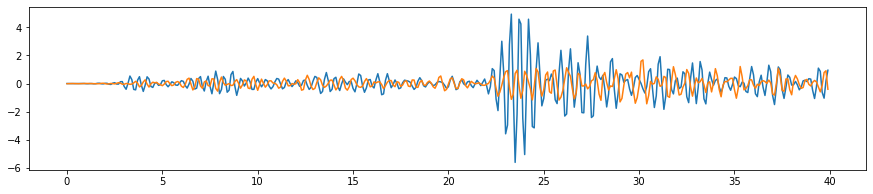

In [20]:
i = 15
fig, axes = plt.subplots(1,1,figsize=(15,3))
plt.plot(np.arange(400)*0.1, das_data[i])
plt.plot(np.arange(400)*0.1, das_predict_td[i])
# plt.plot(np.arange(400)*0.1, das_predict_td_corrected[i])

In [21]:
# for i in range(das_data.shape[0]):
#     fig, axes = plt.subplots(1,1,figsize=(15,3))
#     plt.plot(np.arange(400)*0.1, das_data[i])
#     plt.plot(np.arange(400)*0.1, das_predict_td[i])
#     plt.plot(np.arange(400)*0.1, das_predict_td_corrected[i])
#     plt.savefig(f"tmpplots/{i}.pdf")
#     plt.close(fig)

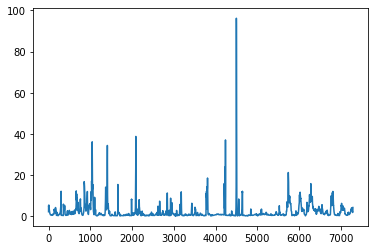

In [22]:
plt.plot(np.mean(np.square(das_predict_td_s-das_data_s), axis=1))

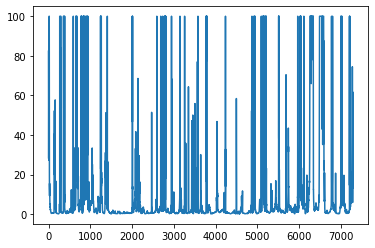

In [23]:
plt.plot(np.clip(np.mean(np.square(das_predict_td_corrected_s-das_data_s), axis=1),0,100))

In [24]:
np.argmax(np.mean(np.square(das_predict_td_corrected_s-das_data_s), axis=1))

2786

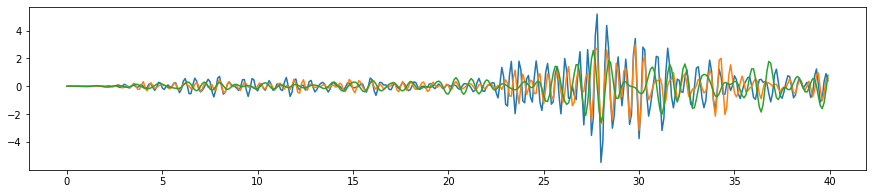

In [50]:
i = 2786
fig, axes = plt.subplots(1,1,figsize=(15,3))
plt.plot(np.arange(400)*0.1, das_data_s[i])
plt.plot(np.arange(400)*0.1, das_predict_td_s[i])
plt.plot(np.arange(400)*0.1, 1e-4*das_predict_td_corrected_s[i])

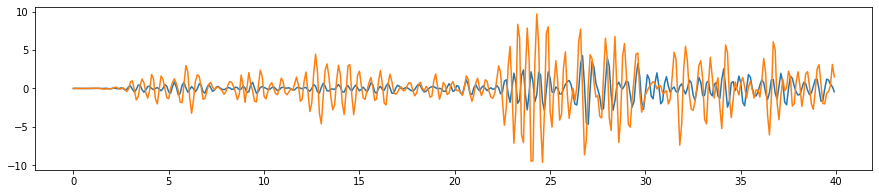

In [158]:
i = 1100
fig, axes = plt.subplots(1,1,figsize=(15,3))
plt.plot(np.arange(400)*0.1, das_data[i])
plt.plot(np.arange(400)*0.1, das_predict_td[i])


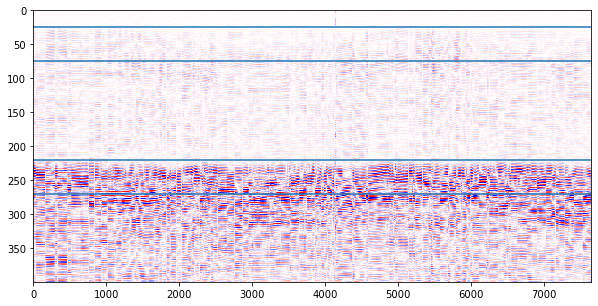

In [98]:
plt.figure(figsize=(10,5))
plt.imshow(das_data.T, cmap='seismic', aspect='auto')
plt.axhline(25)
plt.axhline(75)

plt.axhline(220)
plt.axhline(270)

0.7546031273828588 0.013709340362054678


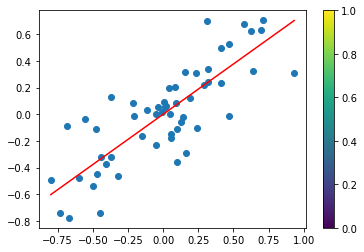

In [63]:
jj1 = 20
jj2 = 75
plt.scatter(das_data[i,jj1:jj2], das_predict_td[i,jj1:jj2])
slope, intercept = siegelslopes(das_predict_td[i,jj1:jj2], das_data[i,jj1:jj2])
x = np.linspace(np.min(das_data[i,jj1:jj2]), np.max(das_data[i,jj1:jj2]), 10)
plt.plot(x, x*slope,'r')
plt.colorbar()
print(slope, intercept)

In [26]:
das_data_s_fft = np.fft.rfft(das_data_s)
das_predict_td_s_fft = np.fft.rfft(das_predict_td_s)
das_data_fft = np.fft.rfft(das_data)
das_predict_td_fft = np.fft.rfft(das_predict_td)
freqs = np.fft.rfftfreq(das_data_s.shape[1], 0.1)

In [27]:
for i in range(das_data.shape[0]):
    fig, axes = plt.subplots(1,1,figsize=(5,3))
    plt.plot(freqs, np.abs(das_data_fft[i]))
    plt.plot(freqs, np.abs(das_predict_td_fft[i]))
    plt.savefig(f"tmpplots/{i}.pdf")
    plt.close(fig)


In [28]:
from scipy.ndimage.filters import uniform_filter1d

def running_mean_rms(trace1, trace2, bin_width=10):
    running_mean_power_ratio = (uniform_filter1d(np.square(trace1), size=bin_width) /
                                uniform_filter1d(np.square(trace2), size=bin_width))
    return np.sqrt(running_mean_power_ratio)
    

In [69]:
rms_amp_diff = np.array([running_mean_rms(t1,t2,bin_width=100) for t1,t2 in zip(das_predict_td,das_data)])

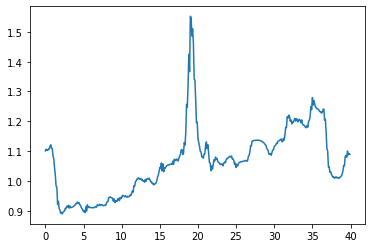

In [70]:
plt.plot(np.arange(400)*0.1,rms_amp_diff[2700])

In [105]:
p_rms = np.sqrt(np.mean(np.square(das_data[:,25:75]), axis=1))/np.sqrt(np.mean(np.square(das_predict_td[:,25:75]), axis=1))
s_rms = np.sqrt(np.mean(np.square(das_data[:,220:270]), axis=1))/np.sqrt(np.mean(np.square(das_predict_td[:,220:270]), axis=1))

(array([6.040e+02, 1.591e+03, 1.861e+03, 1.478e+03, 9.620e+02, 4.890e+02,
        2.800e+02, 1.200e+02, 8.900e+01, 6.200e+01, 1.700e+01, 2.600e+01,
        2.200e+01, 1.200e+01, 4.000e+00, 8.000e+00, 3.000e+00, 5.000e+00,
        5.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        4.000e+00]),
 array([0.09356841, 0.36038749, 0.62720657, 0.89402564, 1.16084472,
        1.42766379, 1.69448287, 1.96130195, 2.22812102, 2.4949401 ,
        2.76175917, 3.02857825, 3.29539733, 3.5622164 , 3.82903548,
        4.09585455, 4.36267363, 4.62949271, 4.89631178, 5.16313086,
        5.42994993, 5.69676901, 5.96358809, 6.23040716, 6.49722624,
        6.76404531]),
 <a list of 25 Patch objects>)

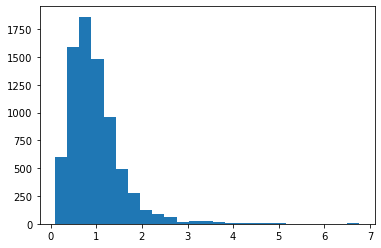

In [109]:
plt.hist(s_rms, bins=25)

In [112]:
e = np.load('tmp/proj_1.npy')
n = np.load('tmp/proj_2.npy')

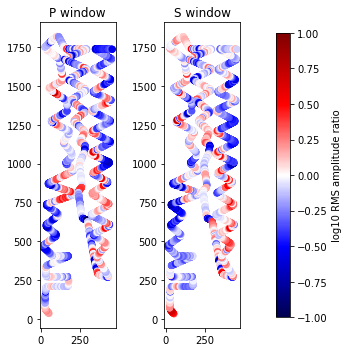

In [156]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(5,5))
norm = mpl.colors.Normalize(vmin=-1, vmax=1)

cax = axes[0].scatter(e,n,c=np.log10(p_rms), cmap='seismic', norm=norm)
axes[0].set_title("P window")
axes[0].set_aspect('equal')
axes[1].scatter(e,n,c=np.log10(s_rms), cmap='seismic', norm=norm)
axes[1].set_title("S window")
axes[1].set_aspect('equal')

fig.colorbar(cax,fraction=0.1, use_gridspec=True, pad=0.25, label="log10 RMS amplitude ratio")
fig.tight_layout()